In [45]:
import cv2
import numpy as np
from imutils import perspective
import matplotlib.pyplot as plt
import pytesseract
import math

In [46]:
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [47]:
path = "transcript.jpg"
width = 600
height = 800

In [48]:
img = cv2.imread(path)
img = cv2.resize(img, (width, height))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (3, 3), 1)
img_canny = cv2.Canny(img_blur, 10, 70)
kernel = np.ones((3, 3), np.uint8)
img_dilated = cv2.dilate(img_canny, kernel, iterations=1)

img_equalized = cv2.equalizeHist(img_gray)


img_adaptive_thresh = cv2.adaptiveThreshold(img_equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

kernel_sharpening = np.array([[-1,-1,-1],
                              [-1, 9,-1],
                              [-1,-1,-1]])
img_sharpened = cv2.filter2D(img_adaptive_thresh, -1, kernel_sharpening)

(-0.5, 599.5, 799.5, -0.5)

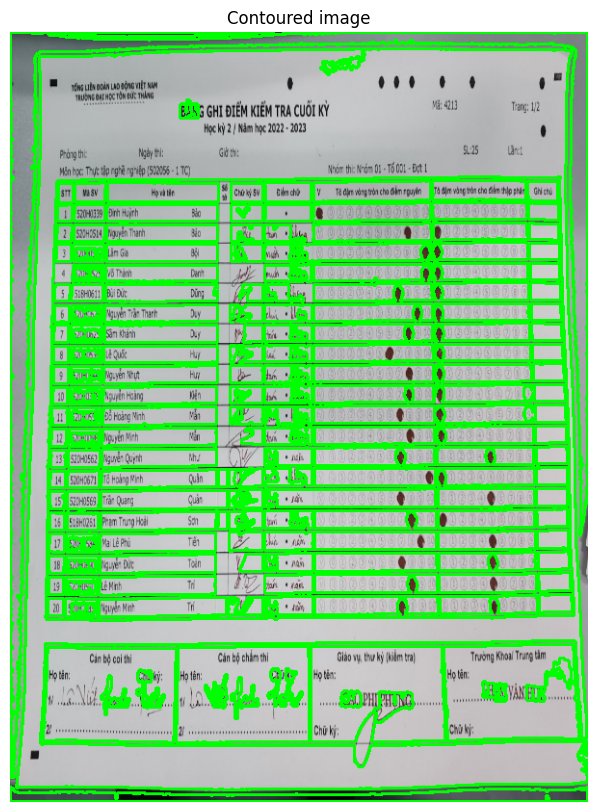

In [49]:
# Find contours
contours, hierarchy = cv2.findContours(img_sharpened, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

filtered_contour_area = []
# Draw contours on an image for visualization
cont_img = img.copy()
# cv2.drawContours(cont_img, contours, -1, (0, 255, 0), 2)
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 250:
        filtered_contour_area.append(contour)
        
cv2.drawContours(cont_img, filtered_contour_area, -1, (0, 255, 0), 2)
cont_img_rgb = cv2.cvtColor(cont_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(25, 10))

plt.imshow(cv2.cvtColor(cont_img_rgb, cv2.COLOR_BGR2RGB))
plt.title('Contoured image')
plt.axis('off')

In [50]:
# Find the second largest contour
contour_areas = [(cv2.contourArea(contour), i) for i, contour in enumerate(contours)]
contour_areas.sort(reverse=True)
second_largest_contour_index = contour_areas[1][1]
second_largest_contour = contours[second_largest_contour_index]

# Approximate the contour's shape with fewer vertices
epsilon = 0.03 * cv2.arcLength(second_largest_contour, True)
corners = cv2.approxPolyDP(second_largest_contour, epsilon, True)

#sort corner, rotate left 90 degrees
center = (width // 2, height // 2)
angles = np.arctan2(corners[:, 0, 1] - center[1], corners[:, 0, 0] - center[0])
sorted_indices = np.argsort(angles)
sorted_corners = corners[sorted_indices]

output_size = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
sorted_corners = np.float32(sorted_corners[:, 0, :])

# Calculate the perspective transformation matrix
matrix = cv2.getPerspectiveTransform(sorted_corners, output_size)
warped_image = cv2.warpPerspective(img, matrix, (width, height))



(-0.5, 599.5, 799.5, -0.5)

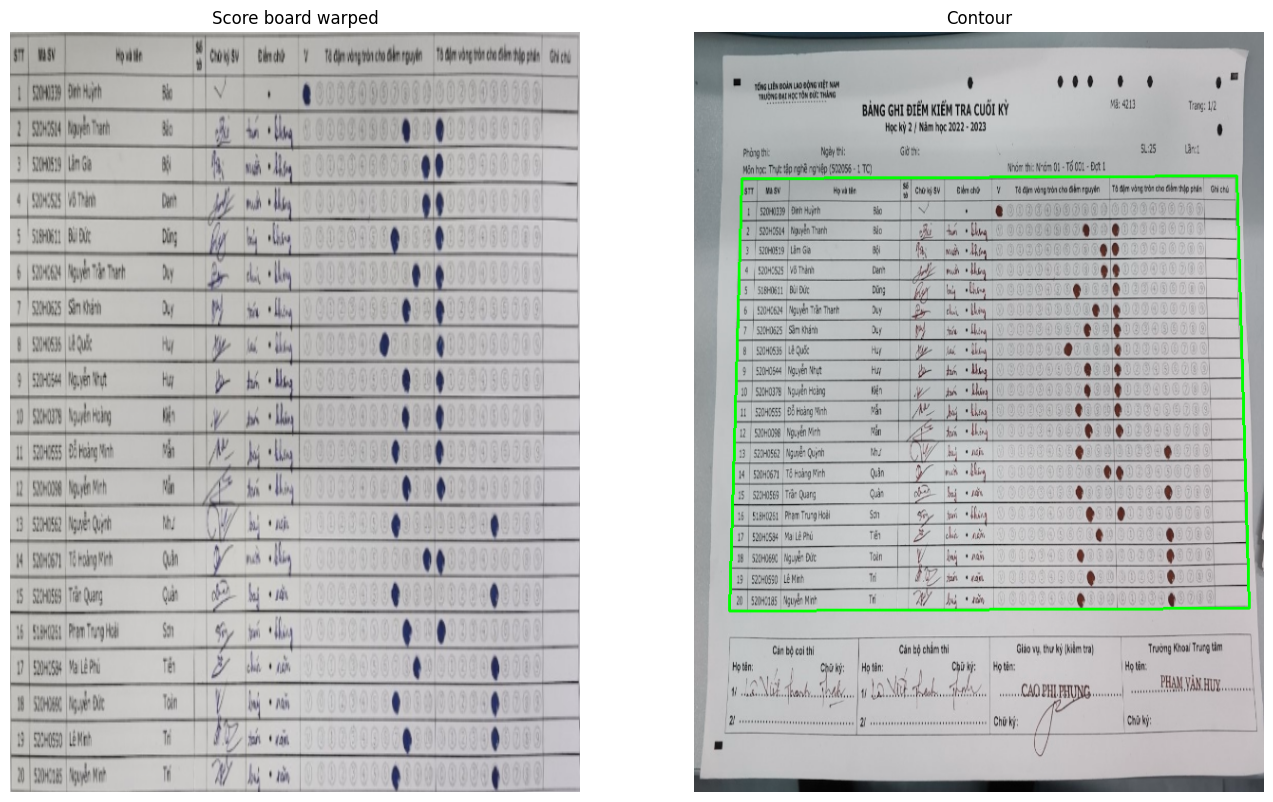

In [51]:
#Display result
plt.figure(figsize=(25, 10))

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.title('Score board warped')
plt.axis('off')

canvas = img.copy()
cv2.drawContours(canvas, [sorted_corners.astype(int)], -1, (0, 255, 0), 2)

plt.subplot(1, 3, 3)
plt.imshow(canvas)
plt.title('Contour')
plt.axis('off')

In [53]:
# image = warped_image
# res = image.copy()
# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# blurred_image = cv2.GaussianBlur(gray_image, (9, 9), 2)
# circles = cv2.HoughCircles(
#     blurred_image, cv2.HOUGH_GRADIENT, dp=1, minDist=50, param1=200, param2=30, minRadius=10, maxRadius=100
# )

# scores = []
# print(circles)
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     for circle in circles[0, :]:
#         center = (circle[0], circle[1])
#         radius = circle[2]
        
#         cv2.circle(res, center, radius, (0, 255, 0), 2)


In [54]:
image = warped_image.copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find number of rows
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,1))
horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
rows = 0

for c in cnts:
    cv2.drawContours(image, [c], -1, (36,255,12), 2)
    rows += 1
rows

22

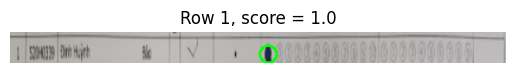

417.0 452.5


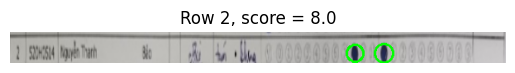

437.5 451.0


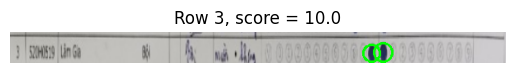

438.0 452.5


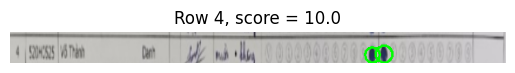

405.0 451.5


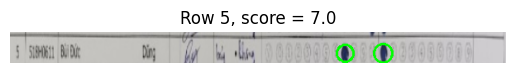

427.0 452.0


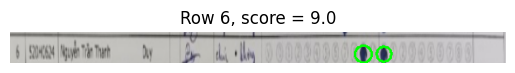

416.5 452.0


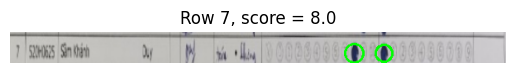

394.0 453.0


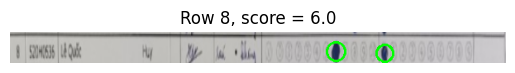

417.5 452.0


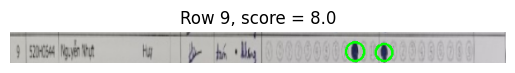

416.0 452.0


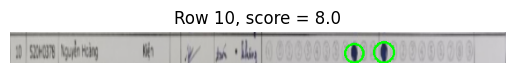

405.5 451.5


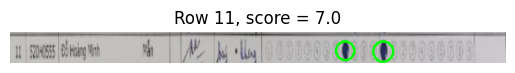

417.5 453.5


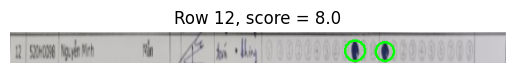

406.0 510.0


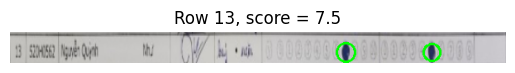

439.0 453.0


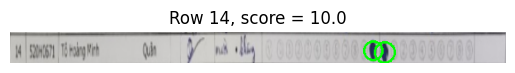

405.5 509.5


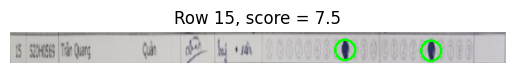

417.0 453.5


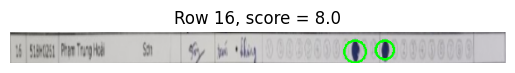

428.0 510.0


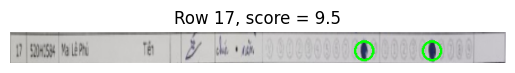

406.0 510.5


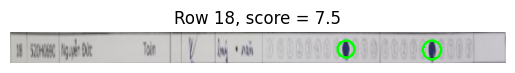

417.0 510.5


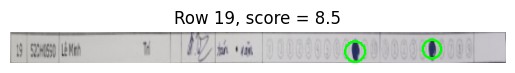

405.5 511.0


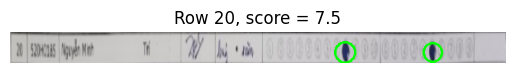

In [55]:
image = warped_image.copy()

num_rows = rows - 1
num_circles = 10
circle_radius = 15
circle_spacing = 3

# pytesseract_config = r'--oem 3 --psm 7'

row_height = image.shape[0] // num_rows



for row_index in range(1, num_rows):
    
    y_start = row_index * row_height
    y_end = y_start + row_height

    row_image = image[y_start:y_end, :]
    
    row_gray = cv2.cvtColor(row_image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding
    _, thresholded_row = cv2.threshold(row_gray, 100, 50, cv2.THRESH_BINARY_INV)
    dot_contours, _ = cv2.findContours(thresholded_row, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the minimum enclosing circle for each dot contour
    circles = []
    for dot_contour in dot_contours:
        (x, y), radius = cv2.minEnclosingCircle(dot_contour)
        #dots range only
        if (300 <= x <= 525) and (20 < y < 30):
            circles.append((x, y, radius))
    # print(len(circles))
    integer_thresholds = {1: (300, 315), 2: (315, 330), 3: (330, 345), 4: (345, 360), 5: (360, 375), 6: (375, 395), 7: (395, 407), 8: (407, 420), 9: (420, 435), 10: (435, 450)}
    decimal_thresholds = {1: (455, 460), 2: (460, 475), 3: (475, 490), 4: (490, 505), 5: (505, 520), 6: (520, 535), 7: (535, 550), 8: (550, 565), 9: (565, 580), 10: (580, 595)}
    int_score = 0
    dec_score = 0
    
    #do not have the decimal part
    if len(circles) == 1:
        x1, y1, r1 = circles[0]
        for k, v in integer_thresholds.items():
                if v[0] <= x1 <= v[1]:
                    int_score = k
                    break
    #otherwise 
    elif len(circles) == 2:
        x1, y1, r1 = circles[0]
        x2, y2, r2 = circles[1]
       
        if x1 > x2: x1, x2 = x2, x1
        print(x1, x2)
        for k, v in integer_thresholds.items():
                if v[0] <= x1 <= v[1]:
                    int_score = k
                    break
        for k, v in decimal_thresholds.items():
            if v[0] <= x2 <= v[1]:
                dec_score = k
                break
     
 
    # Filter out the circles that are smaller than a threshold
    min_threshold, max_threshold = 9, 14
    mark_circles = [circle for circle in circles if circle[2] > min_threshold and circle[2] < max_threshold]
    
    score = []
    # Draw circles
    for x, y, radius in mark_circles:
        cv2.circle(row_image, (int(x), int(y)), int(radius), (0, 255, 0), 2)
        # print((x, y))
        
    plt.imshow(cv2.cvtColor(row_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Row {row_index}, score = {int_score + dec_score / 10}')
    plt.axis('off')
    plt.show()